# The Oregonator Model


[AMath 586, Spring Quarter 2019](http://staff.washington.edu/rjl/classes/am586s2019/) at the University of Washington. For other notebooks, see [Index.ipynb](Index.ipynb) or the [Index of all notebooks on Github](https://github.com/rjleveque/amath586s2019/blob/master/notebooks/Index.ipynb).

This notebook illustrates use of the [Scipy](https://scipy.org/) routine `odeint` for solving the initial value problem, which is also in older versions of Scipy and has similar capabilities to the `solve_ivp` routine used in [Example_using_solve_ivp.ipynb](Example_using_solve_ivp.ipynb).

This is a simple ODE model for the [Belousov Zhabotinsky reaction](http://www.scholarpedia.org/article/Belousov-Zhabotinsky_reaction), a chemical oscillation.  The latter part of the notebook illustrates how eigenvalues of the Jacobian matrix vary in time and how this plays into stability theory.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


The chemical reactions are most dramatic when they vary in space, as seen for example in this video:  

(You can find many other videos on this phenomenon online)

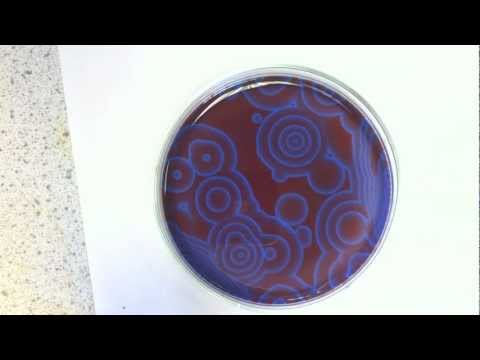

In [2]:
from IPython.display import YouTubeVideo

YouTubeVideo('PpyKSRo8Iec')

Modelling these time-dependent spatial patterns can be done by solving reaction-diffusion equations, partial differential equations in space and time that we will study later in the quarter.

If the reactions take place in a well-stirred container, then oscillatory changes in color can be observed that are spatially uniform and vary only in time, and hence can be modelled with time-dependent ODEs.  We will study ODEs coming from chemical kinetics as a good model problem for numerical methods (see Section 7.4 of the book).

Here's a video accompanied by some discussion of the chemical reactions:

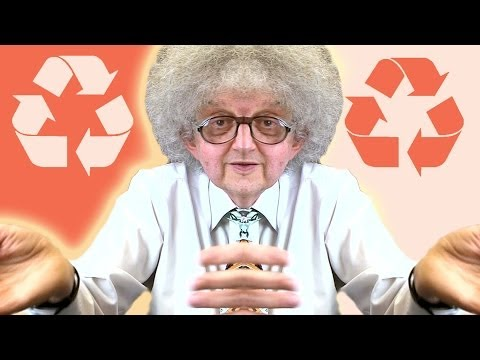

In [3]:
YouTubeVideo('uWh8reiXq58')

## Oregonator model

This model was developed by Field and Noyes at the University of Oregon in 1974, see for example http://www.scholarpedia.org/article/Oregonator

$$
\begin{split}
\epsilon_1 u_0'(t) &= qu_1(t) - u_0(t)u_1(t) + u_0(t)(1 - u_0(t)) \\
\epsilon_2 u_1'(t) &= -qu_1(t) - u_0(t)u_1(t) + \phi u_2(t)\\
u_2'(t) &= u_0(t) - u_2(t)
\end{split}
$$

Note that the vector $u(t)$ has been written with components $u(t) = [u_0(t),~ u_1(t),~ u_2(t)]$  to match the Python convention of 0-based indexing.

### Numerical solution:

We set up the function to compute $f(u,t)$ for this system, with one particular choice of the parameters:

In [4]:
e1 = 0.1 
e2 = 0.1 
q = 0.01 
phi = 1.

def f(u,t):
    f0 = 1./e1 * (q*u[1] - u[0]*u[1] + u[0]*(1.-u[0]))
    f1 = 1./e2 * (-q*u[1] - u[0]*u[1] + phi*u[2])
    f2 = u[0] - u[2]
    f = array([f0, f1, f2])  # return as array rather than list to use in Euler below.
    return f

Set `tout` to be the vector of desired output times, and `eta` to be the initial conditions at time 0:

In [5]:
tout = linspace(0,50,501)
eta = array([1., 1., 1.])

### Use an ODE solver from SciPy:

We first import the solver and then use it.

For documentation, see http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html

In [6]:
from scipy.integrate import odeint

In [7]:
u = odeint(f, eta, tout)

Now plot the solution, using a logarithmic scale so that the oscillations can be seen more clearly.  Label each line so that we can tell which component is which:

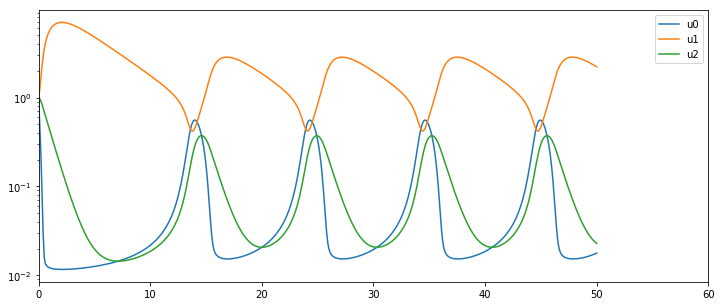

In [8]:
figure(figsize=(12,5))  # make the figure wider than the default
semilogy(tout,u[:,0], label='u0')
semilogy(tout,u[:,1], label='u1')
semilogy(tout,u[:,2], label='u2')
xlim(0,60)  # make room for the legend
legend()  # uses the labels from the plot commands

You can get information about how the ODE solver worked on this problem by setting the `full_output` parameter to `True`, in which case it returns the solution and also a Python dictionary of information.  

In [9]:
u, infodict = odeint(f, eta, tout, full_output=True)

For example, `infodict['hu']` contains the time step used in each step and `infodict['nfe']` the cumulative number of `f` evaluations.  See http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
for more details.

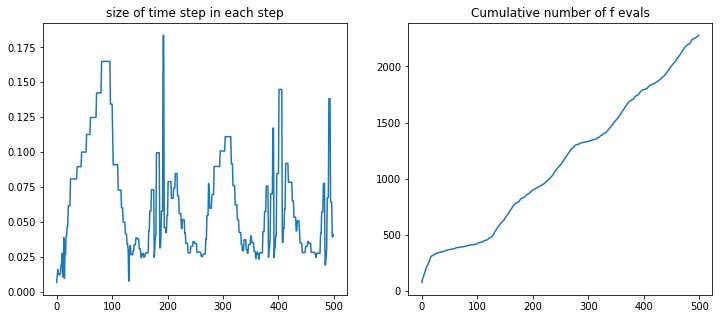

In [10]:
figure(figsize=(12,5))
subplot(1,2,1)
plot(infodict['hu'])
title('size of time step in each step')
subplot(1,2,2)
plot(infodict['nfe'])
title('Cumulative number of f evals')

## Forward Euler method

Here's a simple implementation of Forward Euler for this same problem:

In [11]:
t0 = tout[0]
tfinal = tout[-1]

def euler(nsteps):
    t = linspace(t0, tfinal, nsteps+1)
    dt = t[1] - t[0]
    U = empty((nsteps+1,3))  # array for computed solution
    U[0,:] = eta
    for n in range(nsteps):
        U[n+1,:] = U[n,:] + dt * f(U[n,:], t[n])
        
    figure(figsize=(12,5))
    semilogy(t, U[:,0], label='u0')
    semilogy(t, U[:,1], label='u1')
    semilogy(t, U[:,2], label='u2')
    xlim(0,60)  # make room for the legend
    legend()  # uses the labels from the plot commands
    title('%i steps, dt = %7.4f' % (nsteps, dt))

With 1500 steps the solution looks pretty good, but if the number of steps is reduced to say 1200, (larger $\Delta t$) then it blows up.

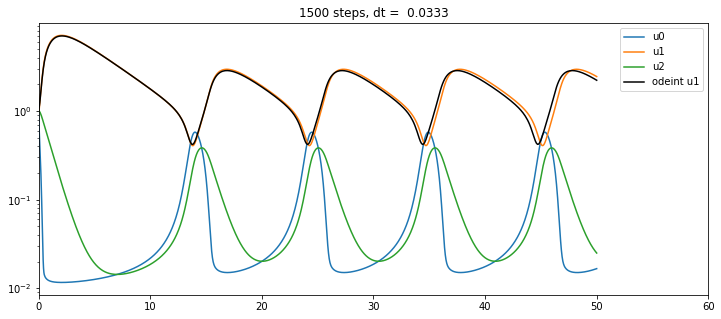

In [30]:
euler(1500)
plot(tout, u[:,1],'k',label='odeint u1') # to compare odeint solution
legend()

## Examine the eigenvalues of the Jacobian matrix:

In [13]:
def J(u,t):
    """
    Jacobian matrix for the Oregonator system.
    Note that it is independent of t for this autonomous system,
    but does depend on u since the problem is nonlinear.
    """
    df1du = 1/e1 * array([-u[1]+1-2*u[0], q-u[0], 0.])
    df2du = 1/e2 * array([-u[1], -q-u[0], phi])
    df3du = array([1., 0., -1.])
    J = vstack((df1du, df2du, df3du))
    return J

In [14]:
def sorted_eig(A):
    """
    Compute the eigenvalues of A and sort them by absolute value
    """
    lam, R = eig(A)
    # Sort eigenvalues:
    i = list(argsort(abs(lam)))
    i.reverse()
    lam = lam[i]
    R = R[:,i]  # reorder eigenvectors the same way
    return lam, R

In [16]:
# Examples:
for utest in ([1,0.1,0.1], [0.4,0.4,0.4]):
    print("\nFor u = %s" % utest)
    Ju = J(utest,0)
    lam, R = sorted_eig(Ju)
    print("Jacobian:\n", Ju)
    print("eigenvalues: ",lam)


For u = [1, 0.1, 0.1]
('Jacobian:\n', array([[-11. ,  -9.9,   0. ],
       [ -1. , -10.1,  10. ],
       [  1. ,   0. ,  -1. ]]))
('eigenvalues: ', array([-14.71202365,  -3.88797635,  -3.5       ]))

For u = [0.4, 0.4, 0.4]
('Jacobian:\n', array([[ -2. ,  -3.9,   0. ],
       [ -4. ,  -4.1,  10. ],
       [  1. ,   0. ,  -1. ]]))
('eigenvalues: ', array([-7.78793113+0.j        ,  0.34396557-1.98475388j,
        0.34396557+1.98475388j]))


Note that for the second choice of u, two of the eigenvalues are complex and in the right half plane. 

### A version of forward Euler that computes and plots eigenvalues of J:

Actually plots $\Delta t \lambda_j$ for  $j = 0,~1,~2$ and compares to the stability region of Forward Euler.

In [18]:
def euler_plot_lam(nsteps):
    t = linspace(t0, tfinal, nsteps+1)
    dt = t[1] - t[0]
    U = empty((3,nsteps+1))  # array for computed solution
    U[:,0] = eta
    
    z = empty((3,nsteps), dtype=complex)
    
    for n in range(nsteps):
        U[:,n+1] = U[:,n] + dt * f(U[:,n], t[n])
        Ju = J(U[:,n], t[n])
        lam, R = sorted_eig(Ju)
        z[:,n] = dt*lam
        
    figure(figsize=(12,8))
    for sp in [1,2]:
        subplot(1,2,sp)
            
        # plot z = k*lam at every time step:
        plot(real(z[0,:]), imag(z[0,:]), 'bo')
        plot(real(z[1,:]), imag(z[1,:]), 'ro')
        plot(real(z[2,:]), imag(z[2,:]), 'go')

        # plot stability region of forward Euler:
        theta = linspace(0, 2*pi, 1000)
        plot(cos(theta)-1., sin(theta), 'k')

        # plot imaginary axis:
        plot([0,0], [-2,2], 'k')

        axis('scaled')
        if sp==1:
            axis([-2.5, 0.5, -1.5, 1.5])
        else:
            axis([-.2,.2,-.2,.2])
                
        title('k*lam at each step')
    
    return t,z

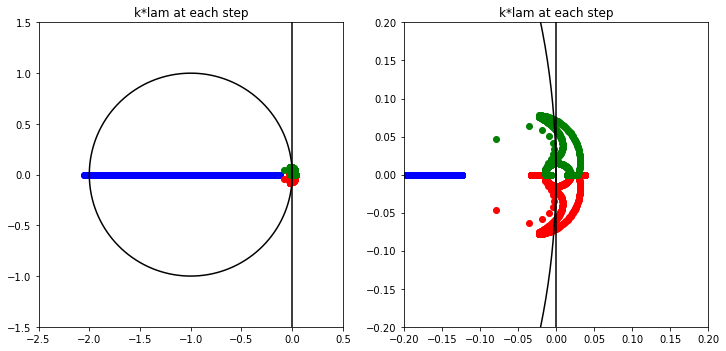

In [19]:
t,z = euler_plot_lam(1500)

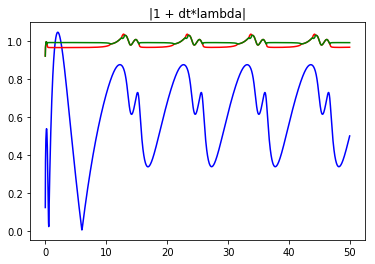

In [20]:
g = abs(1 + z)
plot(t[:-1],g[0,:],'b')
plot(t[:-1],g[1,:],'r')
plot(t[:-1],g[2,:],'g')
title('|1 + dt*lambda|')

Note that we could make $k\lambda$ for the blue eigenvalue stay in the stability region by taking a smaller time step, but the other eigenvalues always stray into the right half plane.

## Backward Euler

In [21]:
def backward_euler(nsteps):
    t = linspace(t0, tfinal, nsteps+1)
    dt = t[1] - t[0]
    U = empty((3,nsteps+1))  # array for computed solution
    U[:,0] = eta
    
    g = lambda u,t,Un: u - Un - dt*f(u,t)
    gprime = lambda u,t: eye(3) - dt*J(u,t)
    
    for n in range(nsteps):
        
        Uhat = U[:,n] # initial guess for Newton iteration
        for j in range(10):
            # Newton iteration
            rhs = -g(Uhat, t[n+1], U[:,n])
            delta = solve(gprime(Uhat,t[n+1]), rhs)
            Uhat = Uhat + delta
            if norm(delta,inf) < 1e-8:
                break
        if j > 9:
            print "*** Possible nonconvergence of Newton, norm(delta,inf) = " \
                    % norm(delta,inf)
            
        U[:,n+1] = U[:,n] + dt * f(Uhat, t[n+1])  # backward Euler update
        
    figure(figsize=(12,5))
    semilogy(t, U[0,:], label='u0')
    semilogy(t, U[1,:], label='u1')
    semilogy(t, U[2,:], label='u2')
    xlim(0,60)  # make room for the legend
    legend()  # uses the labels from the plot commands
    title('%i steps, dt = %7.4f' % (nsteps, dt))

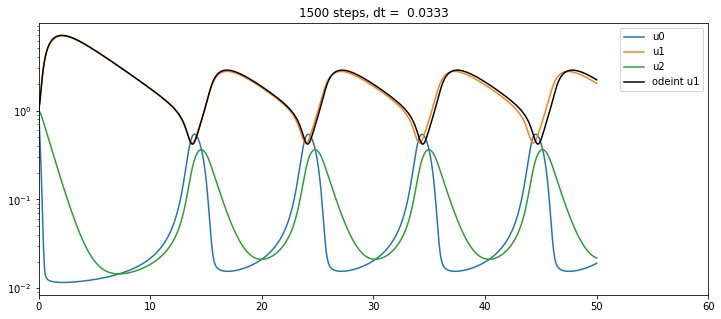

In [25]:
backward_euler(1500)
plot(tout, u[:,1],'k',label='odeint u1') # to compare odeint solution
legend()

This method stays stable for arbitrary `dt` (though maybe not very accurate if `dt` is much larger).